In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 8
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Process Process-3:
Process Process-8:
Process Process-5:
Process Process-6:
Process Process-2:
Process Process-7:
Process Process-4:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rece

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [6]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [7]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
max_frames       = 5000
hidden_size      = 64
lr               = 2.5e-4
num_steps        = 128
mini_batch_size  = 32
ppo_epochs       = 4
print_every      = 500

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
frame_idx    = 0
test_rewards = []

# Important

With GAE: GAE advantage just used for actor loss. Discounted returns used for critic.

In [9]:
## grab random values for each batch
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage, values):
    batch_size = states.size(0)
    sampler = BatchSampler(SubsetRandomSampler(range(batch_size)), 
                           batch_size // mini_batch_size, 
                           drop_last=False)
    for rand_ids in sampler:
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :], values[rand_ids, :]
        
        
def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, values, clip_param=0.1):
    for _ in range(ppo_epochs):
        for s, act, lp, r, adv, v in ppo_iter(mini_batch_size, states, actions, log_probs,
                                                                       returns, advantages, values):
            new_dist, new_value = model(s)
            new_entropy = new_dist.entropy().mean()
            new_log_prob = new_dist.log_prob(act)
            ratio = torch.exp(new_log_prob - lp)
            surr1 = ratio * adv
            surr2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * adv
            actor_loss = - torch.min(surr1, surr2).mean()

            optimizer.zero_grad()
            actor_loss = -(lp * adv.detach()).mean()
            critic_loss = F.mse_loss(r,v)
            loss = (actor_loss + 0.5 * critic_loss - 0.01 * new_entropy).backward(retain_graph=True)
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

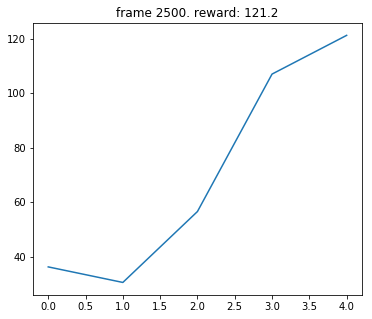

KeyboardInterrupt: 

In [10]:
state = envs.reset()

while frame_idx < max_frames:
    log_probs = []
    values = []
    rewards = []
    masks = []
    states = []
    actions = []
    
    for _ in range(num_steps):
        # state is 16 x 4 because 16 envs
        state = torch.FloatTensor(state).to(device)
        states.append(state)
        # dist and value each have 16 for all envs
        dist, value = model(state)
        
        # have 16 actions
        action = dist.sample()
        actions.append(action)
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        
        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(value)
        # there are 16 rewards. Need to make it 16x1. Same for masks
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
                
        state = next_state
        frame_idx += 1
        
        if frame_idx % print_every == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    log_probs = torch.cat(log_probs).unsqueeze(1).to(device)
    returns = torch.cat(returns).detach().to(device)
    values = torch.cat(values).to(device)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
    states    = torch.cat(states).to(device)
    actions   = torch.cat(actions).unsqueeze(1).to(device)
                        
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, values)

In [ ]:
test_env(True)